<a href="https://colab.research.google.com/github/BenzThitikorn/Vector-Symbol-Decoding-with-AI/blob/main/Data_Generation_Using_PYLDPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/BenzThitikorn/Vector-Symbol-Decoding-with-AI.git


Cloning into 'Vector-Symbol-Decoding-with-AI'...
remote: Enumerating objects: 11753, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 11753 (delta 5), reused 19 (delta 2), pack-reused 11729 (from 2)
Receiving objects: 100% (11753/11753), 52.85 MiB | 22.03 MiB/s, done.
Resolving deltas: 100% (653/653), done.


In [2]:
cd /content/Vector-Symbol-Decoding-with-AI

/content/Vector-Symbol-Decoding-with-AI


In [3]:
!pip install --upgrade pyldpc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyldpc: filename=pyldpc-0.7.9-py3-none-any.whl size=14303 sha256=16117cae650f8c236f4a8706e852ebdace889e84db8592bb3c54cb78b2f0453f
  Stored in directory: /root/.cache/pip/wheels/64/94/ad/d9f332bc2a1e857f54fe35b124d59d27d681f37a0e15b7b027
Successfully built pyldpc


# Code Set Up

In [4]:
n = 30 #Code lenght
r = 16 #Symbol lenght

In [5]:
#LDPC Setting
from pyldpc import make_ldpc
d_v=3
d_c=6
H,Gt = make_ldpc(n, d_v=3, d_c=6, systematic=True, sparse=True, seed=1)
G=Gt.T
j=G.shape[0]
print(f"H matrix: {H.shape[0]} rows, {H.shape[1]} columns")
print(f"G matrix: {G.shape[0]} rows, {G.shape[1]} columns")

H matrix: 15 rows, 30 columns
G matrix: 17 rows, 30 columns


## Function Defined

In [6]:
import Channel_Coding as cc
import numpy as np
from CCv2 import Compute_Gauss_Jordan_Reduction_Optimized, VSD_normal_get0fast

def q_ary_error_channel(prob_error,num):
	rng = np.random.default_rng()
	Probability = [1-prob_error, prob_error]
	channel = rng.choice(2, num, p=Probability)
	return channel

def VSD_normal(H, Y):
    Y_Binary = np.array(Y, dtype=int)

    # Compute Syndrome Matrix
    S_Binary = np.floor(np.mod(np.dot(H, Y_Binary), 2)).astype(int)
    S_Gauss, S_rank, Index_Rows = Compute_Gauss_Jordan_Reduction_Optimized(S_Binary)

    # Compute Error Locating Vector
    Error_Locating_Vector = cc.Compute_Error_Locating_Vector(S_Gauss, Index_Rows, H)

    # Find Number of Erroneous Symbols
    Number_Error = np.count_nonzero(Error_Locating_Vector == 0)

    if Number_Error == 0:
        return Y, 1  # No errors detected

    # Check if Rank of S matches Number of Erroneous Symbols
    if S_rank == Number_Error:
        S_Sub = S_Binary[Index_Rows, :]
        Position_Error = np.where(Error_Locating_Vector == 0)[0]
        H_Sub = H[np.ix_(Index_Rows, Position_Error)]

        # Check if H_Sub is invertible
        if np.linalg.det(H_Sub) == 0:
            #print("normal",H_Sub)
            return Y_Binary, 0  # Cannot correct errors

        H_Sub_inv = np.linalg.inv(H_Sub)
        Error_Binary = np.floor(np.mod(np.dot(H_Sub_inv, S_Sub), 2)).astype(int)

        # Correct the errors
        for index in range(len(Position_Error)):
            Y_Binary[Position_Error[index]] ^= Error_Binary[index]

        Y_decode = Y_Binary  # Decoded output
        return Y_decode, 1  # Successful correction
    else:
        return Y_Binary, 0  # Unable to correct errors




# Simulation Step

In [7]:
from scipy.sparse import random as sparse_random

num_samples = 1
SER = 0.1
j=G.shape[0]
for i in range(num_samples):
  error_positions = q_ary_error_channel(SER,n)
  message = np.random.randint(0, 2, (r, j))
  codeword = np.matmul(message, G).astype(np.int8) % 2
  error = np.zeros_like(codeword)
  error[:, error_positions == 1] = sparse_random(r, np.sum(error_positions), density=0.5, format='csr', dtype=int).toarray() % 2
  Y = (codeword + error) % 2
  Y_decode, success = VSD_normal(H, Y.T)
  if success == 1:
    print("Decoding successful")
  else:
    print("Decoding failed")


if np.array_equal(Y_decode.T, codeword):
  print("All decoded values match codeword")
else:
  print("Decoded values don't match codeword")

Decoding successful
All decoded values match codeword


In [8]:
import numpy as np
from scipy.sparse import random as sparse_random
from tqdm import tqdm
import pickle  # Import pickle for saving data

def generate_data(num_samples, SER, H, G):
    """
    Generate training data for the LDPC code decoder with tqdm progress.
    Stores X and Y if the process is interrupted.

    Parameters:
    - num_samples: Number of samples to generate
    - SER: Symbol Error Rate
    - H: Parity check matrix
    - G: Generator matrix

    Returns:
    - X: Array of syndromes (features)
    - Y: Array of error positions (labels)
    """
    X = []
    Y = []

    try:
        for i in tqdm(range(num_samples), desc="Generating Data"):
            error_positions = q_ary_error_channel(SER, n)
            message = np.random.randint(0, 2, (r, j))
            codeword = np.matmul(message, G).astype(np.int8) % 2
            error = np.zeros_like(codeword)
            error[:, error_positions == 1] = sparse_random(r, np.sum(error_positions), density=0.5, format='csr', dtype=int).toarray() % 2
            received = (codeword + error) % 2
            syndrome = np.dot(H, received.T) % 2
            Y_decode, success = VSD_normal_get0fast(H, received.T)

            if success == 0:
                X.append(syndrome)
                Y.append((error_positions + 1) % 2)

    except KeyboardInterrupt:
        print("\nGeneration interrupted. Saving progress...")
        with open("interrupted_data.pkl", "wb") as f:
            pickle.dump({"X": X, "Y": Y}, f)
        print("Progress saved to interrupted_data.pkl")
        return np.array(X).astype(bool), np.array(Y).astype(bool) #return the data that was generated.

    print(f"\nGenerated {len(X)} samples from {num_samples} iterations")
    return np.array(X).astype(bool), np.array(Y).astype(bool)

In [18]:
X,Y = generate_data(num_samples=5000000, SER=0.1, H=H, G=G)


Generating Data: 100%|██████████| 5000000/5000000 [52:17<00:00, 1593.78it/s]



Generated 1178605 samples from 5000000 iterations


In [19]:
np.save('X_data.npy', X)
np.save('Y_data.npy', Y)

In [20]:
X2 = np.load('X2_data.npy')
Y2 = np.load('Y2_data.npy')

In [21]:
X_new = np.concatenate((X, X2), axis=0)
Y_new = np.concatenate((Y, Y2), axis=0)

In [25]:
X_new.shape

(1761305, 15, 16)

In [29]:
import numpy as np

def get_unique_x_and_y(X, Y):
    """
    Filters X and Y to keep only unique X values and their corresponding Y values.

    Args:
        X: NumPy array of shape (num_samples, 15, 16).
        Y: NumPy array of shape (num_samples, ...). Y can have any shape, but the first dimension must match X.

    Returns:
        unique_X: NumPy array containing only unique X values.
        unique_Y: NumPy array containing the corresponding Y values.
    """

    if X.shape[0] != Y.shape[0]:
        raise ValueError("X and Y must have the same number of samples (first dimension).")

    unique_indices = []
    seen_X = set()

    for i in range(X.shape[0]):
        x_tuple = tuple(X[i].flatten())  # Flatten X[i] for hashing

        if x_tuple not in seen_X:
            seen_X.add(x_tuple)
            unique_indices.append(i)

    unique_X = X[unique_indices]
    unique_Y = Y[unique_indices]

    return unique_X, unique_Y



In [31]:
unique_X, unique_Y = get_unique_x_and_y(X_new, Y_new)

In [34]:
np.save('unique_X.npy', unique_X)
np.save('unique_Y.npy', unique_Y)

In [36]:
unique_X.shape

(1701943, 15, 16)

# Fun Space

In [41]:
from numpy.random import randint
A = randint(0, 2, (50, 50))

In [42]:
import time
import numpy as np

# Get results from both implementations
start_time = time.time()
result1, rank1, rows1 = cc.Compute_Gauss_Jordan_Reduction(A)
time1 = time.time() - start_time

start_time = time.time()
result2, rank2, rows2 = Compute_Gauss_Jordan_Reduction_Optimized(A)
time2 = time.time() - start_time

# Check if results are equal
matrices_equal = np.array_equal(result1, result2)
ranks_equal = rank1 == rank2
rows_equal = rows1 == rows2

print(f"Matrices equal: {matrices_equal}")
print(f"Ranks equal: {ranks_equal}")
print(f"Row indices equal: {rows_equal}")
print(f"Time for original method: {time1:.6f} seconds")
print(f"Time for optimized method: {time2:.6f} seconds")
print(f"Speedup: {time1/time2:.2f}x")

# Overall equality
all_equal = matrices_equal and ranks_equal and rows_equal
print(f"All results equal: {all_equal}")


Matrices equal: True
Ranks equal: True
Row indices equal: True
Time for original method: 0.084836 seconds
Time for optimized method: 0.001907 seconds
Speedup: 44.50x
All results equal: True


In [ ]:
import numpy as np

def Compute_Gauss_Jordan_Reduction_Optimized(Original_matrix):
    Binary_matrix = np.array(Original_matrix, dtype=int)
    index_operation_col = 0
    rows = 0
    Index_Rows = []
    num_rows, num_cols = Binary_matrix.shape

    while rows < num_rows and index_operation_col < num_cols:
        columns_one = np.where(Binary_matrix[rows, :] == 1)[0]
        if len(columns_one) > 0:
            if index_operation_col in columns_one:
                other_indices = columns_one[columns_one != index_operation_col]
                if len(other_indices) > 0:
                    Binary_matrix[:, other_indices] ^= Binary_matrix[:, [index_operation_col]]
                Index_Rows.append(rows)
                index_operation_col += 1
                rows += 1
            else:
                change_index_col = columns_one[columns_one > index_operation_col]
                if len(change_index_col) > 0:
                    Binary_matrix[:, [index_operation_col, change_index_col[0]]] = Binary_matrix[:, [change_index_col[0], index_operation_col]]
                else:
                    rows += 1
        else:
            rows += 1
    return Binary_matrix, index_operation_col, Index_Rows

Testing different matrix sizes: 100%|██████████| 3/3 [00:11<00:00,  3.99s/it]



Performance Summary:
Matrix Size | Original (s) | Optimized (s) | Speedup
-------------------------------------------------------
         50 |     0.059497 |     0.001280 |   46.49x
        100 |     0.416340 |     0.006206 |   67.09x
        200 |     3.490306 |     0.017464 |  199.85x


Testing different matrix sizes: 100%|██████████| 6/6 [08:03<00:00, 80.63s/it] 



Performance Summary:
Matrix Size | Original (s) | Optimized (s) | Speedup
-------------------------------------------------------
         50 |     0.054361 |     0.001492 |   36.43x
        100 |     0.454784 |     0.004767 |   95.40x
        200 |     3.577924 |     0.017132 |  208.84x
        300 |    11.807967 |     0.043392 |  272.12x
        400 |    27.391578 |     0.115921 |  236.29x
        500 |    53.074652 |     0.202580 |  261.99x


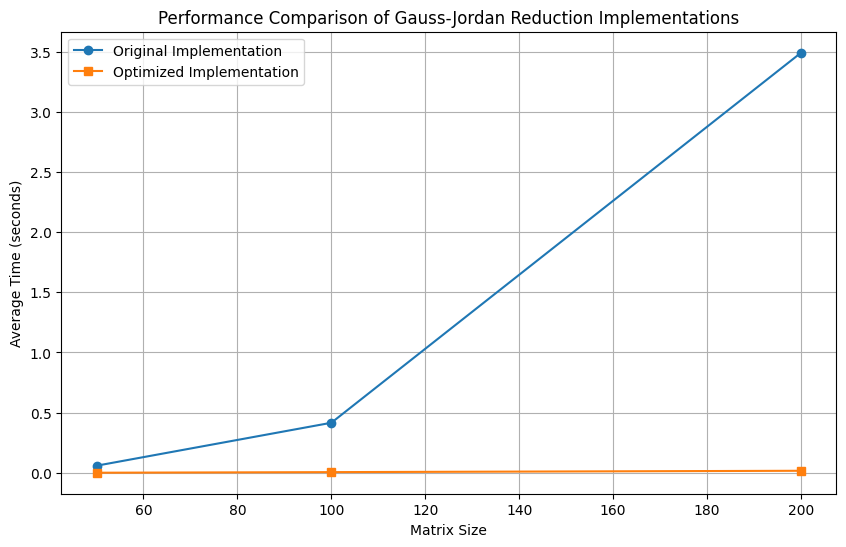

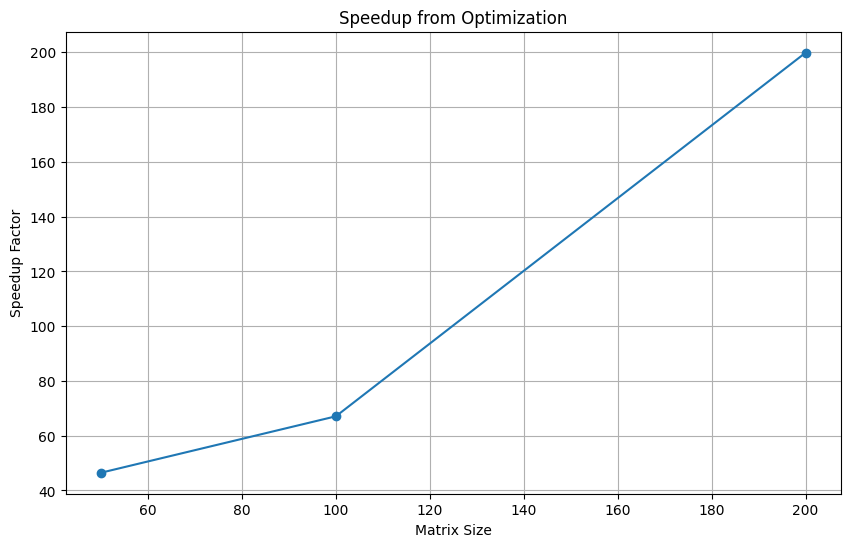

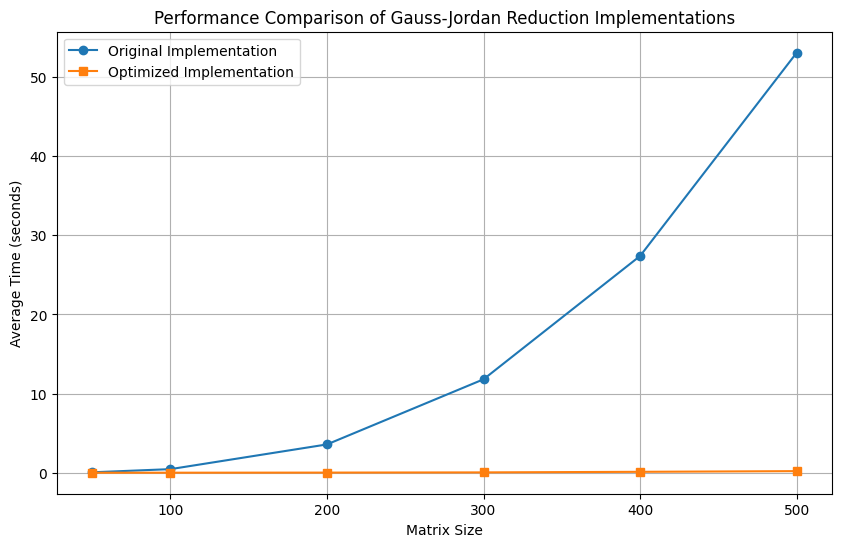

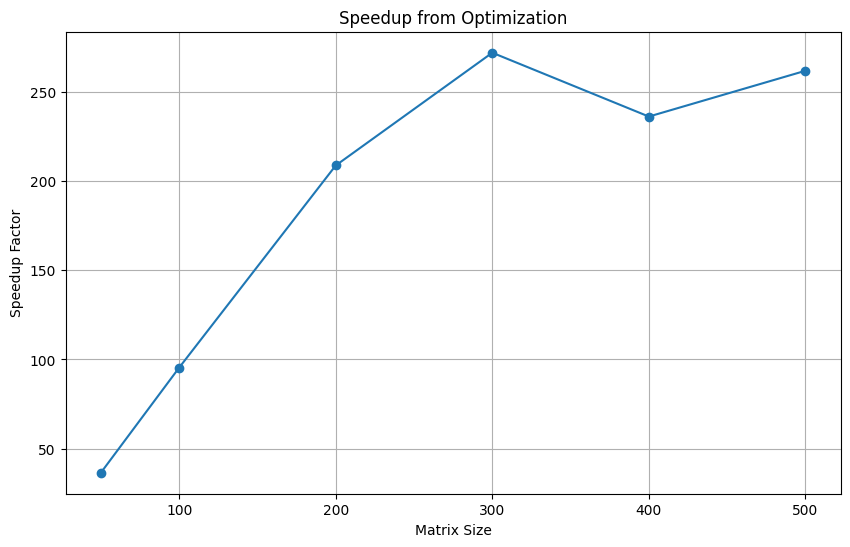

In [ ]:
import numpy as np
import time
from tqdm import tqdm

import matplotlib.pyplot as plt

def compare_gauss_jordan_implementations(matrix_sizes=[50, 100, 200, 300, 400, 500], trials=5):
    times_original = []
    times_optimized = []

    for size in tqdm(matrix_sizes, desc="Testing different matrix sizes"):
        time_orig = 0
        time_opt = 0

        for _ in range(trials):
            # Generate random binary matrix
            test_matrix = np.random.randint(0, 2, (size, size))

            # Time original implementation
            start = time.time()
            gauss_orig, rank_orig, rows_orig = cc.Compute_Gauss_Jordan_Reduction(test_matrix)
            time_orig += time.time() - start

            # Time optimized implementation
            start = time.time()
            gauss_opt, rank_opt, rows_opt = Compute_Gauss_Jordan_Reduction_Optimized(test_matrix)
            time_opt += time.time() - start

            # Verify results match
            if not np.array_equal(gauss_orig, gauss_opt) or rank_orig != rank_opt:
                print(f"Warning: Results don't match for matrix size {size}")

        times_original.append(time_orig / trials)
        times_optimized.append(time_opt / trials)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(matrix_sizes, times_original, 'o-', label='Original Implementation')
    plt.plot(matrix_sizes, times_optimized, 's-', label='Optimized Implementation')
    plt.xlabel('Matrix Size')
    plt.ylabel('Average Time (seconds)')
    plt.title('Performance Comparison of Gauss-Jordan Reduction Implementations')
    plt.legend()
    plt.grid(True)

    # Calculate speedup
    speedup = [t1/t2 for t1, t2 in zip(times_original, times_optimized)]
    plt.figure(figsize=(10, 6))
    plt.plot(matrix_sizes, speedup, 'o-')
    plt.xlabel('Matrix Size')
    plt.ylabel('Speedup Factor')
    plt.title('Speedup from Optimization')
    plt.grid(True)

    # Print summary
    print("\nPerformance Summary:")
    print("Matrix Size | Original (s) | Optimized (s) | Speedup")
    print("-" * 55)
    for i, size in enumerate(matrix_sizes):
        print(f"{size:11d} | {times_original[i]:12.6f} | {times_optimized[i]:12.6f} | {speedup[i]:7.2f}x")

    return {
        'matrix_sizes': matrix_sizes,
        'times_original': times_original,
        'times_optimized': times_optimized,
        'speedup': speedup
    }

# Run comparison with smaller matrices first for testing
results = compare_gauss_jordan_implementations(matrix_sizes=[50, 100, 200], trials=3)

# If successful, run with larger matrices
results = compare_gauss_jordan_implementations()